In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
library(tidyr)
library(ggrepel)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & IsFunctional==1 & Origin=="Tumor")

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")

potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

# read drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt")

# read interactions
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = plyr::revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))

ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,partnerSymbol) %>%
    
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > 0, "Gain", Tag)) %>%
    merge(switches)

ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Parsed with column specification:
cols(
  .default = col_integer(),
  Symbol = col_character(),
  Normal_transcript = col_character(),
  Tumor_transcript = col_character(),
  Normal_protein = col_character(),
  Tumor_protein = col_character(),
  DriverAnnotation = col_character(),
  Origin = col_character(),
  Tumors = col_character(),
  Percentage = col_double(),
  Patients_affected = col_character(),
  p.pam.me = col_double(),
  p.mut.o = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  Tumor = col_character(),
  Symbol = col_character(),
  Normal_transcript = col_character(),
  Tumor_transcript = col_character(),
  Normal_prote

# Tumor

In [2]:
# switches with ppi info
num.ppiSwitches <- ppi.split %>% select(Normal_transcript,Tumor_transcript) %>% unique %>% nrow
num.Switches <- switches.split %>% select(Normal_transcript,Tumor_transcript) %>% unique %>% nrow

num.ppiSwitches/num.Switches

[1] 0.2089387

Loading required package: RColorBrewer


What,n,Proportion
Gain,418,2.330768
Loss,3649,20.346827
Unaffected,13867,77.322404


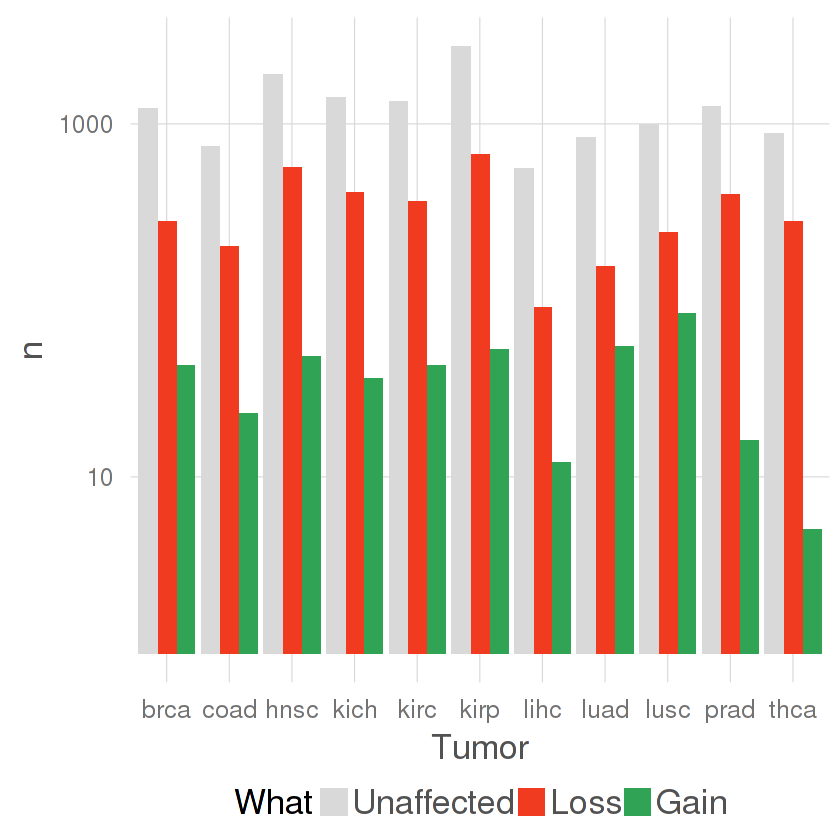

In [3]:
ppi.split %>%
    count(Tumor,What) %>%
    mutate(What = factor(What, levels = c("Unaffected","Loss","Gain"))) %>%
    ggplot(aes(x=Tumor, y=n, fill = What)) + 
        geom_bar(stat="identity",position="dodge") +
        scale_y_log10() +
        clean_theme() +
        theme(legend.position="bottom") +
        scale_fill_manual(values = ppiPalette) +
        labs(y="n", fill="What")

ppi.split %>%
    count(Tumor,What) %>%
    group_by(What) %>%
    summarise(n = sum(n)) %>%
    mutate(Proportion = n/sum(n) * 100)

## Trends across categories

We will check if the bulk of interactions tend to involve a switch in a particular set of genes eg drivers. We know that drivers, for several reasons, will have more interactions. However, a comparison between the proportions of "Kept" interactions and "Gained"/"Lost" should reveal differential behaviour.

## Drivers

### Tumor specific


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric




	Pearson's Chi-squared test

data:  .
X-squared = 67.827, df = 2, p-value = 1.868e-15


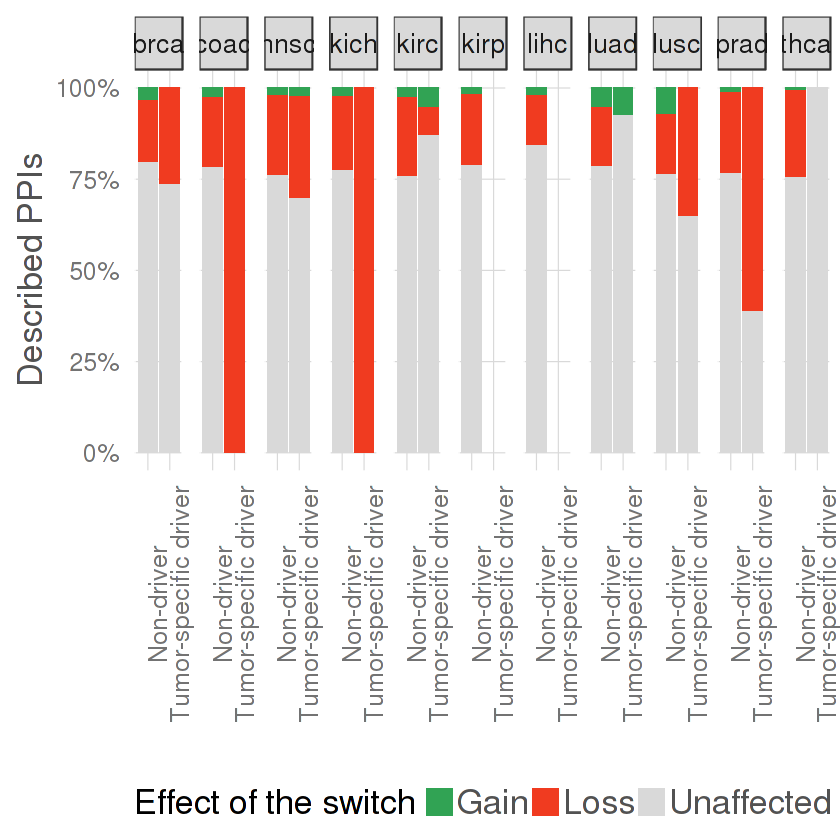

In [4]:
library(scales)

ppi.split %>%
    mutate(SpecificDriver = ifelse(SpecificDriver==1, "Tumor-specific driver", "Non-driver")) %>%
    ggplot(aes(x=SpecificDriver, fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Tumor)

ppi.split %>%
    select(SpecificDriver,What) %>%
    table %>%
    chisq.test

The proportion of gained, lost and kept interactions changes from drivers to non-drivers. Drivers (only specific drivers used) tend to lose more interactions and to gain less.

### Pancancer drivers


	Pearson's Chi-squared test

data:  .
X-squared = 64.098, df = 2, p-value = 1.206e-14


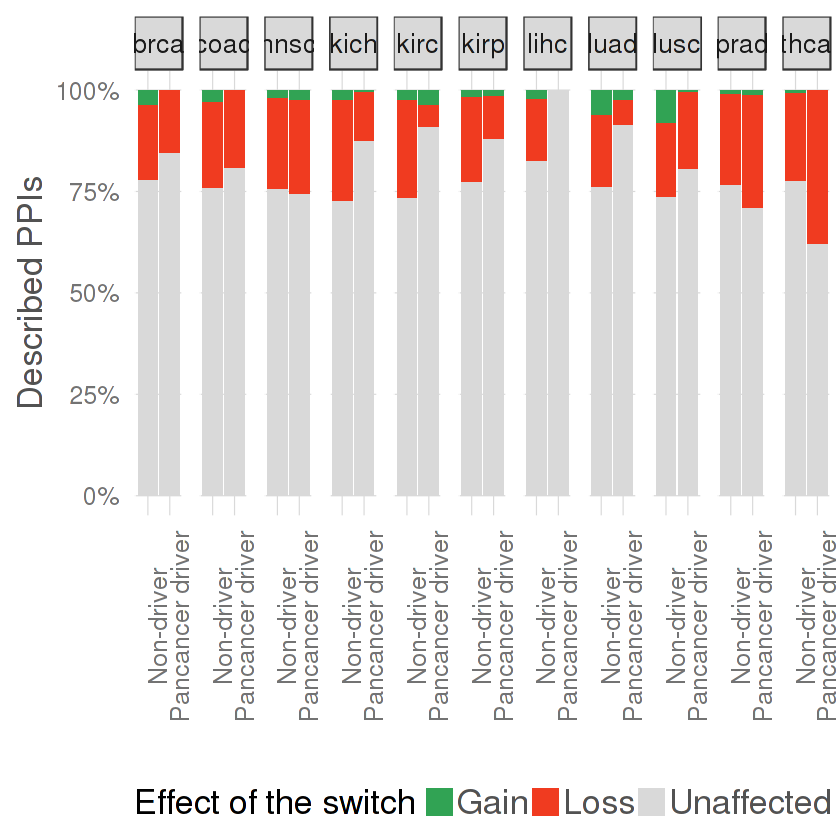

In [5]:
ppi.split %>%
    mutate(Driver = ifelse(Driver==1, "Pancancer driver", "Non-driver")) %>%
    ggplot(aes(x=Driver,fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Tumor)

ppi.split %>%
    select(Driver,What) %>%
    table %>%
    chisq.test

The effect is loss when we consider any driver type, implying that the effect is tissue-specific.

### Driver interactors

Parsed with column specification:
cols(
  X1 = col_integer(),
  X2 = col_integer(),
  X3 = col_character()
)


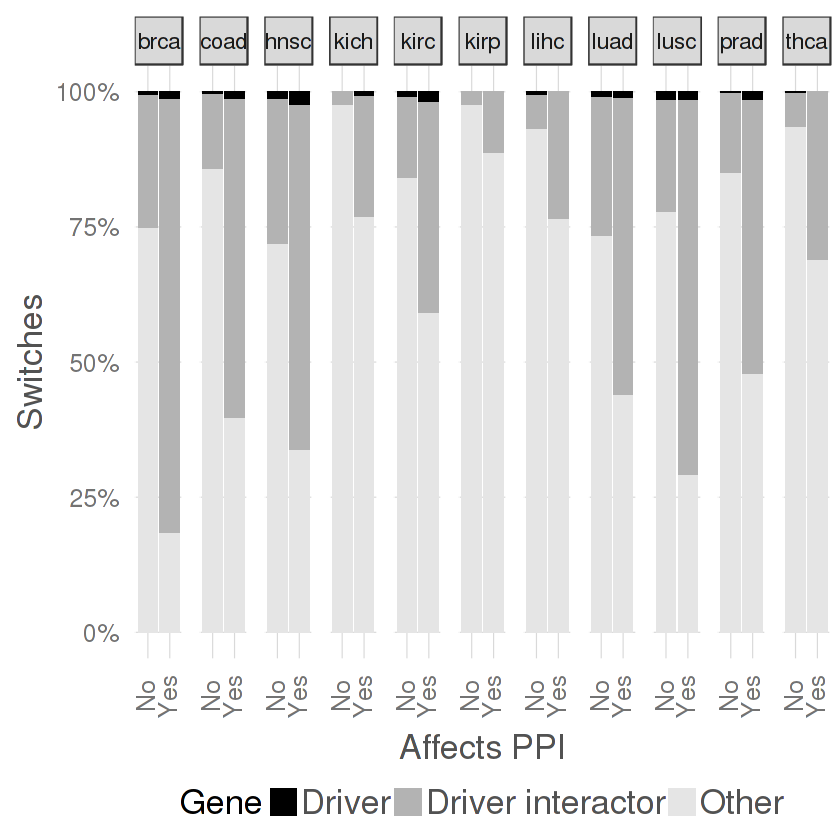

In [6]:
id2symbol <- proteome %>%
    select(GeneId,Symbol) %>%
    unique

ppi.network <- read_tsv("../data/eporta/raw_tables/interactions_found_more_than_three_times.txt", col_names = F) %>%
    select(-X3) %>%
    set_colnames(c("Gene1","Gene2")) %>%
    merge(id2symbol, by.x = "Gene1", by.y = "GeneId") %>%
    merge(id2symbol, by.x = "Gene2", by.y = "GeneId", suffixes = c("","2")) %>%
    set_colnames(c("Gene1","Gene2","Symbol1","Symbol2"))

driver.ppi.network <- ppi.network %>%
    filter(Symbol1 %in% drivers$Symbol | Symbol2 %in% drivers$Symbol)

d1 <- lapply(cancerTypes, function(tumor){
    tumor.drivers <- drivers %>%
        filter(Tumor == tumor)
    
    driver.ppi.network %>%
        mutate(Symbol1 = ifelse(Symbol1 %in% tumor.drivers$Symbol, "", Symbol1),
               Symbol2 = ifelse(Symbol2 %in% tumor.drivers$Symbol, "", Symbol2)) %>%
        # get cases with one driver
        filter(Symbol1 == "" | Symbol2 == "") %>%
        # remove cases with two drivers
        filter(Symbol1 != "" | Symbol2 != "") %>%
        mutate(Symbol = paste0(Symbol1, Symbol2),
               Tumor = tumor, d1 = TRUE) %>%
        select(Symbol, Tumor, d1)
}) %>% do.call("rbind",.)

switches.split %>%
    merge(d1, all.x = T) %>%
    mutate(d1 = ifelse(is.na(d1), FALSE, d1),
           Gene = ifelse(d1,"Driver interactor","Other"),
           Gene = ifelse(SpecificDriver == 1, "Driver", Gene),
           PPI = ifelse(PPI == 1, "Yes", "No")) %>%
    select(Tumor, Gene, PPI) %>%
    ggplot(aes(x = PPI, fill = Gene)) +
        geom_bar(position = "fill") +
        labs(y = "Switches", x = "Affects PPI") +
        clean_theme() +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90, vjust = 0.4),
              strip.text.x = element_text(size = 13) ) +
        scale_y_continuous(labels = percent) +
        scale_fill_manual(values = c("Driver" = "black", "Driver interactor" = "gray70", "Other" = "gray90")) +
        facet_grid(.~Tumor)

In [7]:
switches.split %>%
    merge(d1, all.x = T) %>%
    mutate(d1 = ifelse(is.na(d1), FALSE, d1),
           Gene = ifelse(d1,"Driver interactor","Other"),
           Gene = ifelse(SpecificDriver == 1, "Driver", Gene),
           PPI = ifelse(PPI == 1, "Yes", "No")) %>%
    # remove drivers: they barely contribute and make chi'squeare inexact
    filter(Gene != "Driver") %>%
    group_by(Tumor) %>%
    summarise(p = table(Gene, PPI) %>% fisher.test %>% .$p.value,
              # take reverse odds ratio
              OR = table(Gene, PPI) %>% fisher.test %>% .$estimate %>% log2 %>% abs %>% 2^.)

Tumor,p,OR
brca,1.478349e-45,13.226398
coad,1.400933e-18,9.093934
hnsc,9.443906e-32,5.035422
kich,2.346656e-17,11.787046
kirc,2.717142e-13,3.698164
kirp,2.769702e-09,5.391863
lihc,1.807187e-03,4.505296
luad,8.556326e-09,3.570747
lusc,1.956937e-33,8.834406
prad,1.871096e-21,6.129363


## Candidate switches

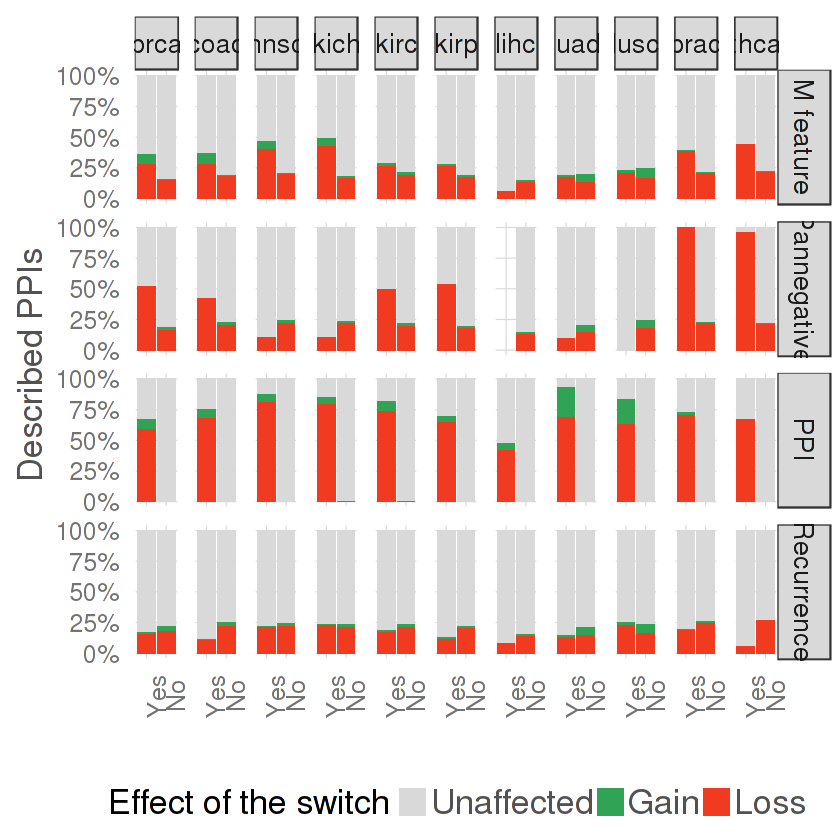

In [8]:
ppi.split %>%
    select(Tumor,What,Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    # convert to long format and reannotate the columns
    reshape2::melt(id.vars = c("Tumor","What"),variable.name = "Indication", value.name = "Altered") %>%
    mutate(Altered = ifelse(Altered > 0,"Yes","No"),
           Altered = factor(Altered, levels=c("Yes","No")),
           What = factor(What,levels=c("Unaffected","Gain","Loss")),
           Indication = ifelse(Indication=="Affects_mutated_feature", "M feature", as.character(Indication))) %>%
    # plot
    ggplot(aes(x = Altered, fill = What)) + 
        geom_bar(position = "fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(Indication~Tumor)

We split the candidates by category. The most important change comes probably from the *M feature* candidates ie the candidates with domains likely to be in tumor drivers. Knowing that drivers have more interactions and are better studied, it is not surprising we are recovering this result: possibly the same domains that help drivers to become hubs allow other genes to do so. Hence, those switches are enriched both in gains and losses.

Recurrent switches do not have this bias though. We observe how they also tend to lose more interactions than the rest of the switches but gain less too. This reveals their possible impact on the PPI network and gives an explanation of their recurrence.

# Pancancer

In [9]:
# contradictory cases
gains <- ppi$Gain > 0
losses <- ppi$Loss > 0
unaffected <- ppi$Unaffected > 0

sum(gains & losses)
sum(unaffected & losses)
sum(unaffected & gains)

summary(ppi$Loss[losses])
summary(ppi$Gain[gains])
summary(ppi$Unaffected[unaffected])

[1] 0

[1] 1

[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.168   3.000   8.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.456   2.000   6.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.224   3.000   9.000 

Most of the cases are coherent, hence we can keep using the tags.

## Categories
### Pancancer-drivers

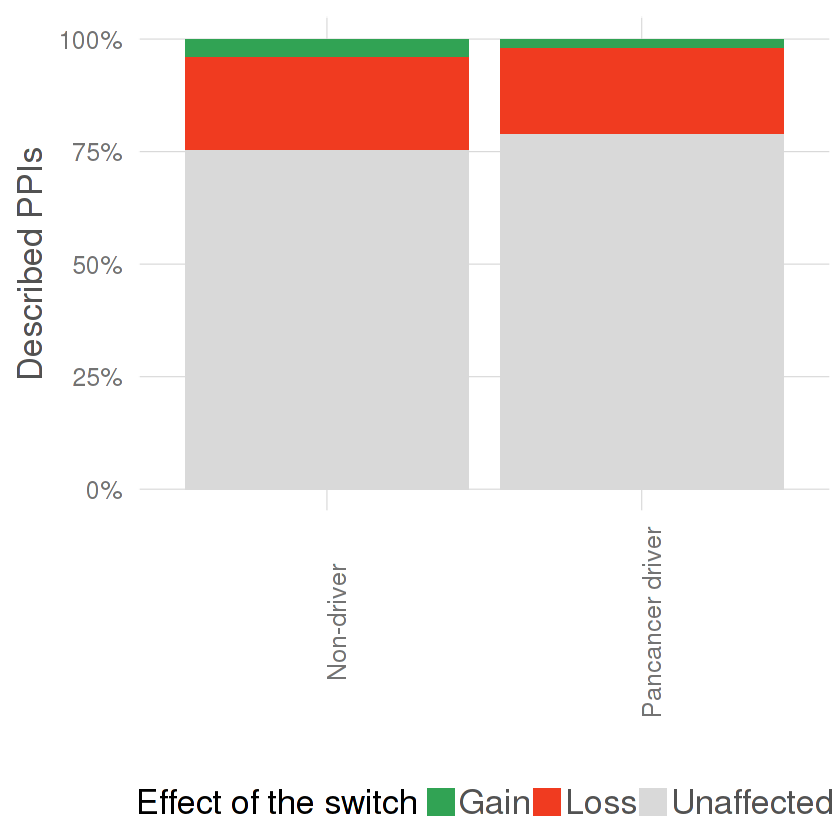

In [10]:
ppi %>%
    mutate(Driver = ifelse(Driver==1, "Pancancer driver", "Non-driver")) %>%
    select(Driver,Gain,Loss,Unaffected) %>%
    reshape2::melt(id.vars = "Driver", variable.name = "What", value.name = "Counts") %>%
    filter(Counts > 0) %>%
    mutate(Counts = as.numeric(Counts > 0)) %>%
    ggplot(aes(x=Driver,fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent)

### Potus


	Pearson's Chi-squared test

data:  .
X-squared = 172.36, df = 2, p-value < 2.2e-16


Warning message in chisq.test(.):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  .
X-squared = 33.004, df = 2, p-value = 6.812e-08


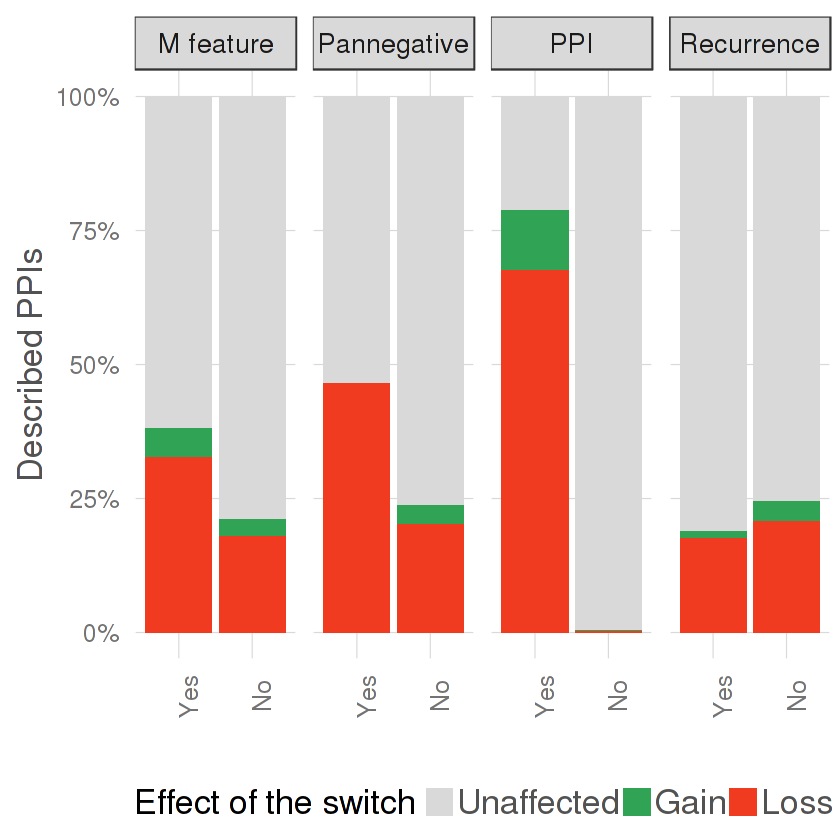

In [11]:
ppi.potus.pancancer <- ppi %>%
    select(Tag,Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    # convert to long format and reannotate the columns
    reshape2::melt(id.vars = "Tag", variable.name = "Indication", value.name = "Altered") %>%
    mutate(Altered = ifelse(Altered > 0,"Yes","No"),
           Altered = factor(Altered, levels=c("Yes","No")),
           Tag = factor(Tag,levels=c("Unaffected","Gain","Loss")),
           Indication = ifelse(Indication=="Affects_mutated_feature", "M feature", as.character(Indication)))
    # plot
ppi.potus.pancancer %>%
    ggplot(aes(x = Altered, fill = Tag)) + 
        geom_bar(position = "fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Indication)

ppi.potus.pancancer %>%
    filter(Indication == "M feature") %>%
    select(Altered,Tag) %>%
    table %>%
    chisq.test

ppi.potus.pancancer %>%
    filter(Indication == "Pannegative") %>%
    select(Altered,Tag) %>%
    table %>%
    chisq.test

This figure is a good summary of the tumor-specific one.

In [12]:
ppi %>% filter(Loss > 0 & PPI == 0)

GeneId,Symbol,Normal_transcript,Tumor_transcript,partnerSymbol,Unaffected,Gain,Loss,Tag,Normal_protein,⋯,MS.pam,M.pam,S.pam,N.pam,p.pam.me,MS.mut,M.mut,S.mut,N.mut,p.mut.o
11244,ZHX1,uc003yqe.2,uc003yqg.2,ZHX3,0,0,3,Loss,Q9UKY1,⋯,0,25,23,3550,0.8514088,0,7,1,87,1.000000
2152,F3,uc001dqr.2,uc001dqp.2,F7,0,0,1,Loss,P13726,⋯,0,6,19,3573,0.9687096,NA,NA,NA,NA,NA
2152,F3,uc001dqr.2,uc001dqp.2,PLG,0,0,1,Loss,P13726,⋯,0,6,19,3573,0.9687096,NA,NA,NA,NA,NA
221662,RBM24,uc003nbz.3,uc011diz.1,A2BP1,0,0,1,Loss,Q9BX46,⋯,0,13,8,3577,0.9714305,NA,NA,NA,NA,NA
2244,FGB,uc003ioa.3,uc003ioc.3,LPA,0,0,1,Loss,P02675,⋯,0,24,7,3567,0.9541940,NA,NA,NA,NA,NA
23406,COTL1,uc002fid.2,uc010chk.2,ACTA1,0,0,2,Loss,Q14019,⋯,0,6,32,3560,0.9477741,NA,NA,NA,NA,NA
26119,LDLRAP1,uc001bkl.3,uc009vrw.2,LDLR,0,0,4,Loss,Q5SW96,⋯,0,11,22,3565,0.9346714,NA,NA,NA,NA,NA
26119,LDLRAP1,uc001bkl.3,uc009vrw.2,LRP2,0,0,2,Loss,Q5SW96,⋯,0,11,22,3565,0.9346714,NA,NA,NA,NA,NA
28988,DBNL,uc003tjp.3,uc011kbs.1,MAP4K1,0,0,3,Loss,Q9UJU6,⋯,0,14,35,3549,0.8718808,0,1,2,43,1.000000
5905,RANGAP1,uc003azu.2,uc003azr.2,RAN,0,0,2,Loss,P46060,⋯,0,22,35,3541,0.8059862,1,7,0,38,0.173913


Those are the few switches were the change in PPI cannot be extrapolated to all tumor-types with this switch. Thay are the cases in the PPI grid, under "No PPI".

## Switches more affected by PPI changes

Selecting by Total


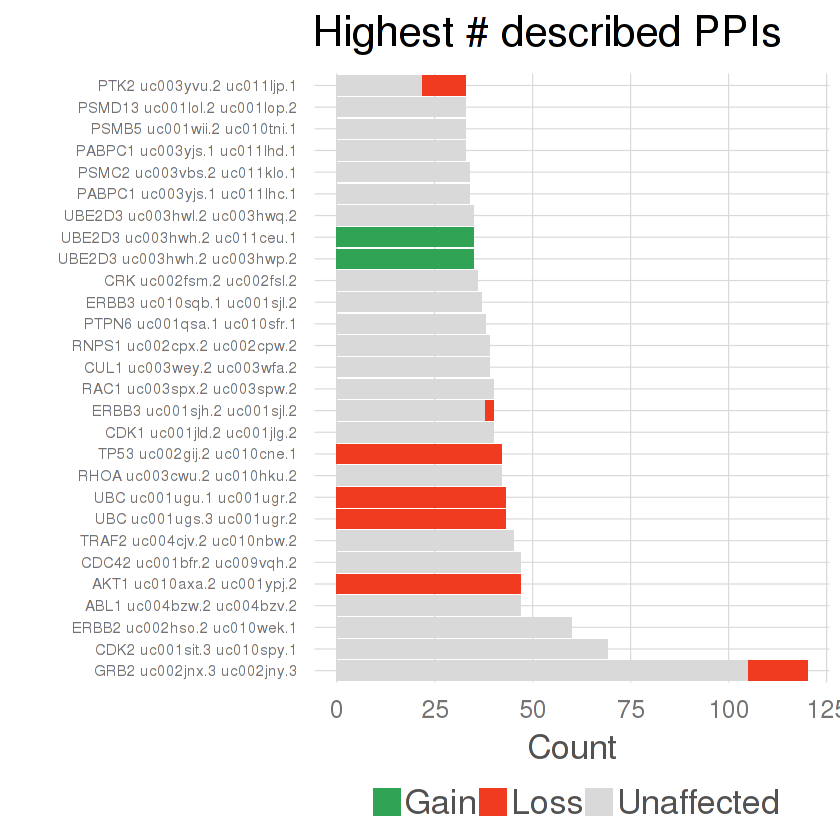

In [13]:
total <- ppi %>%
    count(Symbol, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    group_by(Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(Total = sum(n)) %>%
    ungroup

ppi %>%
    count(Symbol, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    merge(total) %>%
    arrange(desc(Total)) %>% 
    top_n(30)  %>%
    mutate(label = paste(Symbol, Normal_transcript, Tumor_transcript),
           label = factor(label, levels = unique(label))) %>%
    ggplot(aes(x = label, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Highest # described PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

Selecting by n


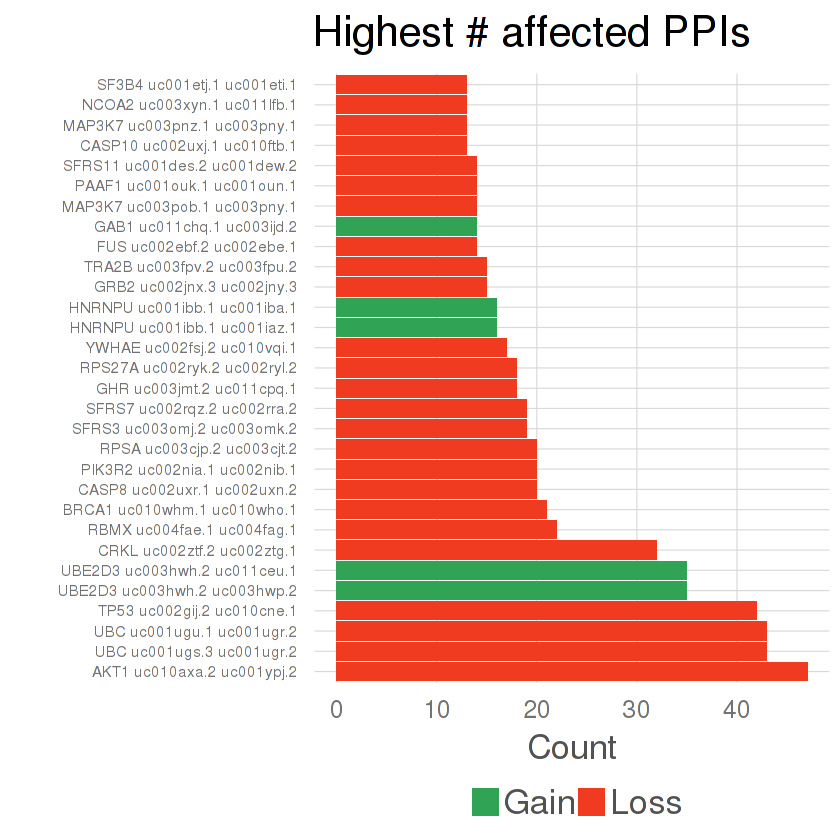

In [14]:
ppi %>%
    count(Symbol, Driver, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
    filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(label = paste(Symbol, Normal_transcript, Tumor_transcript),
           label = factor(label, levels = label)) %>%
    ggplot(aes(x = label, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Highest # affected PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

## Genes more affected by PPI changes due to switches in a partners

Selecting by n


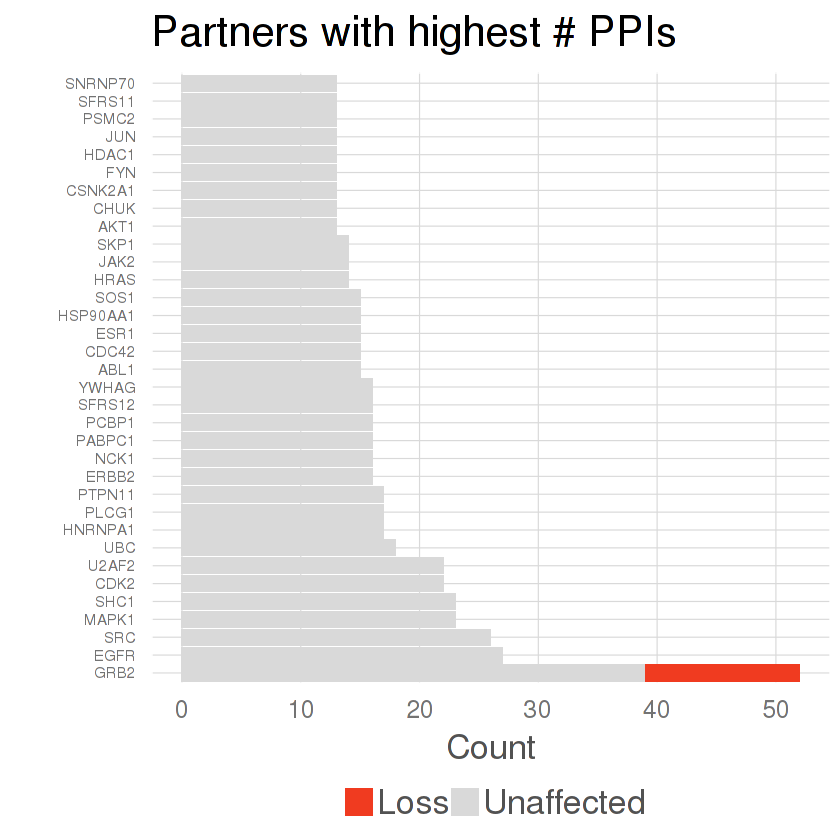

In [15]:
ppi %>%
    count(partnerSymbol,Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
#     filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(partnerSymbol = factor(partnerSymbol, levels = unique(partnerSymbol))) %>%
    ggplot(aes(x = partnerSymbol, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Partners with highest # PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

Selecting by n


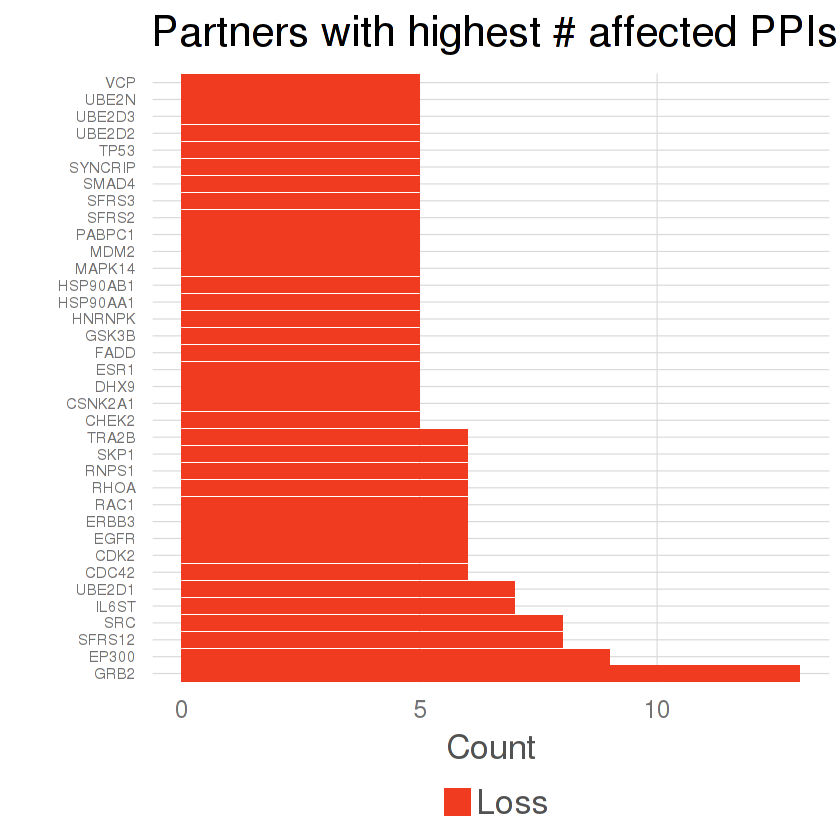

In [16]:
ppi %>%
    count(partnerSymbol,Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
    filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(partnerSymbol = factor(partnerSymbol, levels = unique(partnerSymbol))) %>%
    ggplot(aes(x = partnerSymbol, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Partners with highest # affected PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()